In [1]:


import pandas as pd
from helm.benchmark.runner import InstanceGenerations,GenerationSummary
from typing import Any, List
import json
from helm.common.request import (GeneratedOutput, Token)

import PostMetric
import pandas as pd

from helm.benchmark.metrics.statistic import Stat
from typing import Dict, Optional

from helm.benchmark.augmentations.perturbation_description import (
    PerturbationDescription)
from dataclasses import dataclass
from process_gens import *
from process_gen_utils import *



processGens=ProcessGens()

process_gen_modes=["instruct"]



do_norm_analysis=True
processGens.init_with_mode(process_gen_modes)
root_folder, num_beams_list, models, custom_metrics, task_names, suite_name, instance_metrics, compare_metric = processGens.get_params()
examples_df, completions_df=get_dfs(processGens)

#self-instruct and vicuna

dfs_by_model={}

for model_name in examples_df['model'].unique():
    filtered_df = examples_df[examples_df["model"]==model_name]
    dfs_by_model[model_name]=filtered_df

all_dfs_by_model=dfs_by_model
# if(len(models)>1):
    # all_dfs_by_model["all_models"]=examples_df

/opt/miniconda3/envs/crfm-helm2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
PyTorch version 2.6.0 available.


Init: process_gens_mode ['instruct']


----------------
 NOTE: ONLY PRINTING 4 tasks ----------------

calculate_gen_summary_dict
snellius_copies/helm_output/sample_100_eval_100_first_inst_0/self_instruct_num_respondents_1_/Qwen_Qwen3_8B/1_beams/runs/sample_100_eval_100_first_inst_0
snellius_copies/helm_output/sample_100_eval_100_first_inst_0/anthropic_hh_rlhf_subset_hh_num_respondents_1_/Qwen_Qwen3_8B/1_beams/runs/sample_100_eval_100_first_inst_0
snellius_copies/helm_output/sample_100_eval_100_first_inst_0/vicuna_num_respondents_1_/Qwen_Qwen3_8B/1_beams/runs/sample_100_eval_100_first_inst_0
snellius_copies/helm_output/sample_100_eval_100_first_inst_0/koala_num_respondents_1_/Qwen_Qwen3_8B/1_beams/runs/sample_100_eval_100_first_inst_0
snellius_copies/helm_output/sample_100_eval_100_first_inst_0/anthropic_hh_rlhf_subset_red_team_num_respondents_1_/Qwen_Qwen3_8B/1_beams/runs/sample_100_eval_100_first_inst_0
snellius_copies/helm_output/sample_100_eval_100_first_inst_0/grammar_path_src_hel

In [2]:
print(f"\t root_folder: {root_folder} \n \t num_beams_list {num_beams_list} \n \t models: {models} \n \t custom_metrics{[metric.name() for metric in custom_metrics]}"+ 
    f"\n \t task_names {task_names} \n \t suite_name {suite_name} \n \t instance_metrics {instance_metrics}")
# instanceGeneration=get_first(processGens.first_run_instances)
print(examples_df.head(2))
print("num examples" ,len(examples_df))
print("num_completions", len(completions_df))
print(f"compare_metric mean: ",examples_df[[compare_metric]].mean())
#current belief: for each run_folder combo, there will be 100 instances and 100 examples per instance

	 root_folder: snellius_copies/helm_output 
 	 num_beams_list [1] 
 	 models: ['Qwen_Qwen3_8B'] 
 	 custom_metrics[]
 	 task_names ['self_instruct_num_respondents_1_', 'anthropic_hh_rlhf_subset_hh_num_respondents_1_', 'vicuna_num_respondents_1_', 'koala_num_respondents_1_', 'anthropic_hh_rlhf_subset_red_team_num_respondents_1_', 'grammar_path_src_helm_benchmark_scenarios_best_chatgpt_prompts.yaml_tags_num_respondents_1_'] 
 	 suite_name sample_100_eval_100_first_inst_0 
 	 instance_metrics []
   example_themis  beam_num                         task_name          model  \
0              -1         1  self_instruct_num_respondents_1_  Qwen_Qwen3_8B   
1              -1         1  self_instruct_num_respondents_1_  Qwen_Qwen3_8B   

   example_idx                             suite  instanceID       text  \
0            0  sample_100_eval_100_first_inst_0           0  offensive   
1            1  sample_100_eval_100_first_inst_0           0  offensive   

   completion_length  output_logpro

58000


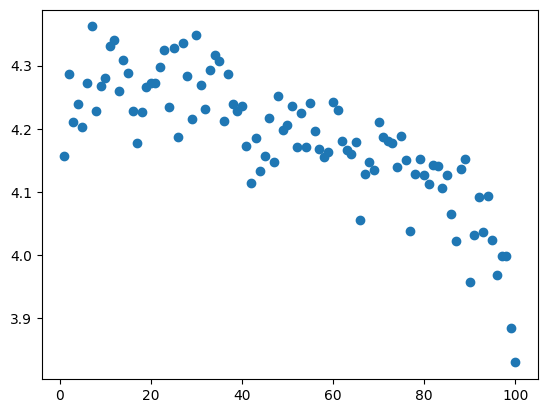

In [10]:
df=examples_df
print(len(df))
# df=next(iter(dfs_by_model.values()))
df["rank"]=100-df["example_idx"]
max_example_idx = examples_df["example_idx"].max()
plots_wide=1
num_models=len(dfs_by_model.keys())
plots_tall=math.ceil(num_models/plots_wide)

suptitle=""
axs=None
fig=None
xlabel="rank"
ylabel=compare_metric
groupby="rank"


grouped = df[[xlabel, ylabel]].groupby(groupby).mean().reset_index()
x=grouped[xlabel]
y=grouped[ylabel]

fig, ax = plt.subplots()

ax.scatter(x, y)



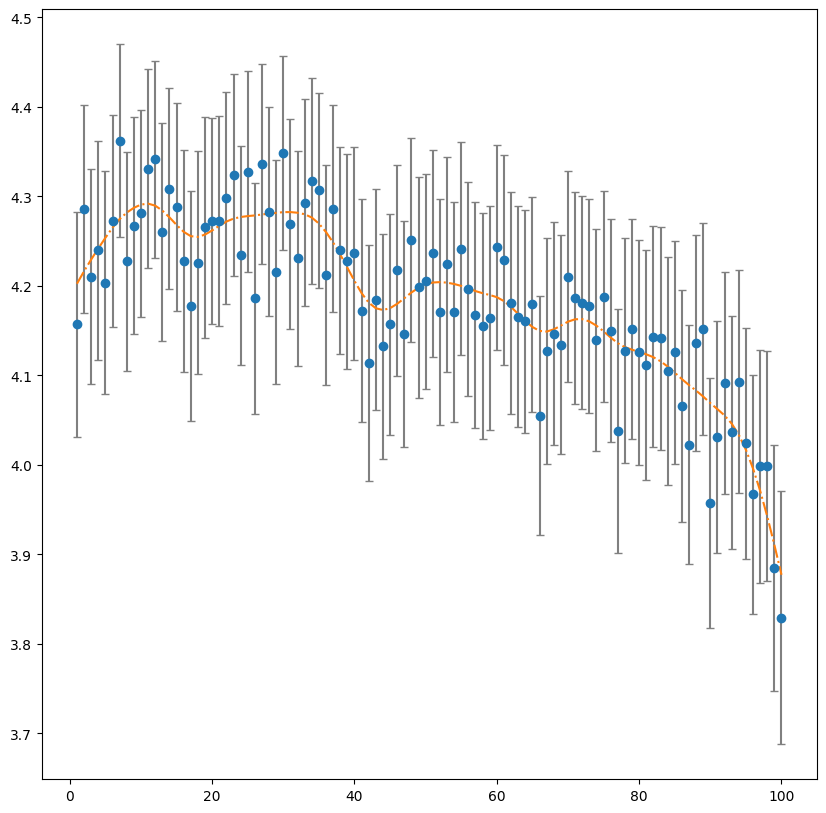

In [14]:
# plot_smooth_spline(examples_df, xlabel, ylabel, groupby='example_idx', title=None, trend_line="None",ax=None, nbins=20, error_bar=False):

def plot_smooth_spline(df, xlabel, ylabel, groupby='example_idx', title=None, trend_line="None",ax=None, nbins=20, error_bar=False, figsize=(50,50)):
    if(ax is None):
        _, ax = plt.subplots(figsize=figsize)
    warnings.simplefilter(action='ignore', category=FutureWarning)
    if(groupby=="bins"):
        
        df["bins"]=pd.qcut(df[xlabel],nbins)
    
    grouped = df.groupby(groupby)[[xlabel, ylabel]].agg(['mean', 'count', 'std'])
    
    grouped = grouped.sort_values(by=(xlabel, 'mean'))

    x = grouped[(xlabel, 'mean')].values
    y = grouped[(ylabel, 'mean')].values
    

    yerr = grouped[(ylabel, 'std')].values
    yerr=[]
    for i in grouped.index:
        # print(grouped.loc[i][ylabel])
        _, c, s = grouped.loc[i][ylabel]
        yerr.append(1.96*s/math.sqrt(c))

    # Plot with error bars (standard deviation)

    if(error_bar):
        ax.errorbar(x, y, yerr=yerr, fmt='o', ecolor='gray', capsize=3, label='Data with std dev')
    else:
        ax.scatter(x,y)
        
    spl = make_smoothing_spline(x, y)
    plt.plot(x, spl(x), '-.')
plot_smooth_spline(df=examples_df, xlabel="rank",groupby='example_idx', ylabel=compare_metric, title=suptitle, figsize=(10,10), error_bar=True)



/opt/miniconda3/envs/crfm-helm2/lib/python3.9/site-packages/cvxpy/problems/problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/lukecadigan/thesis/helm/process_gen_utils.py:517: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


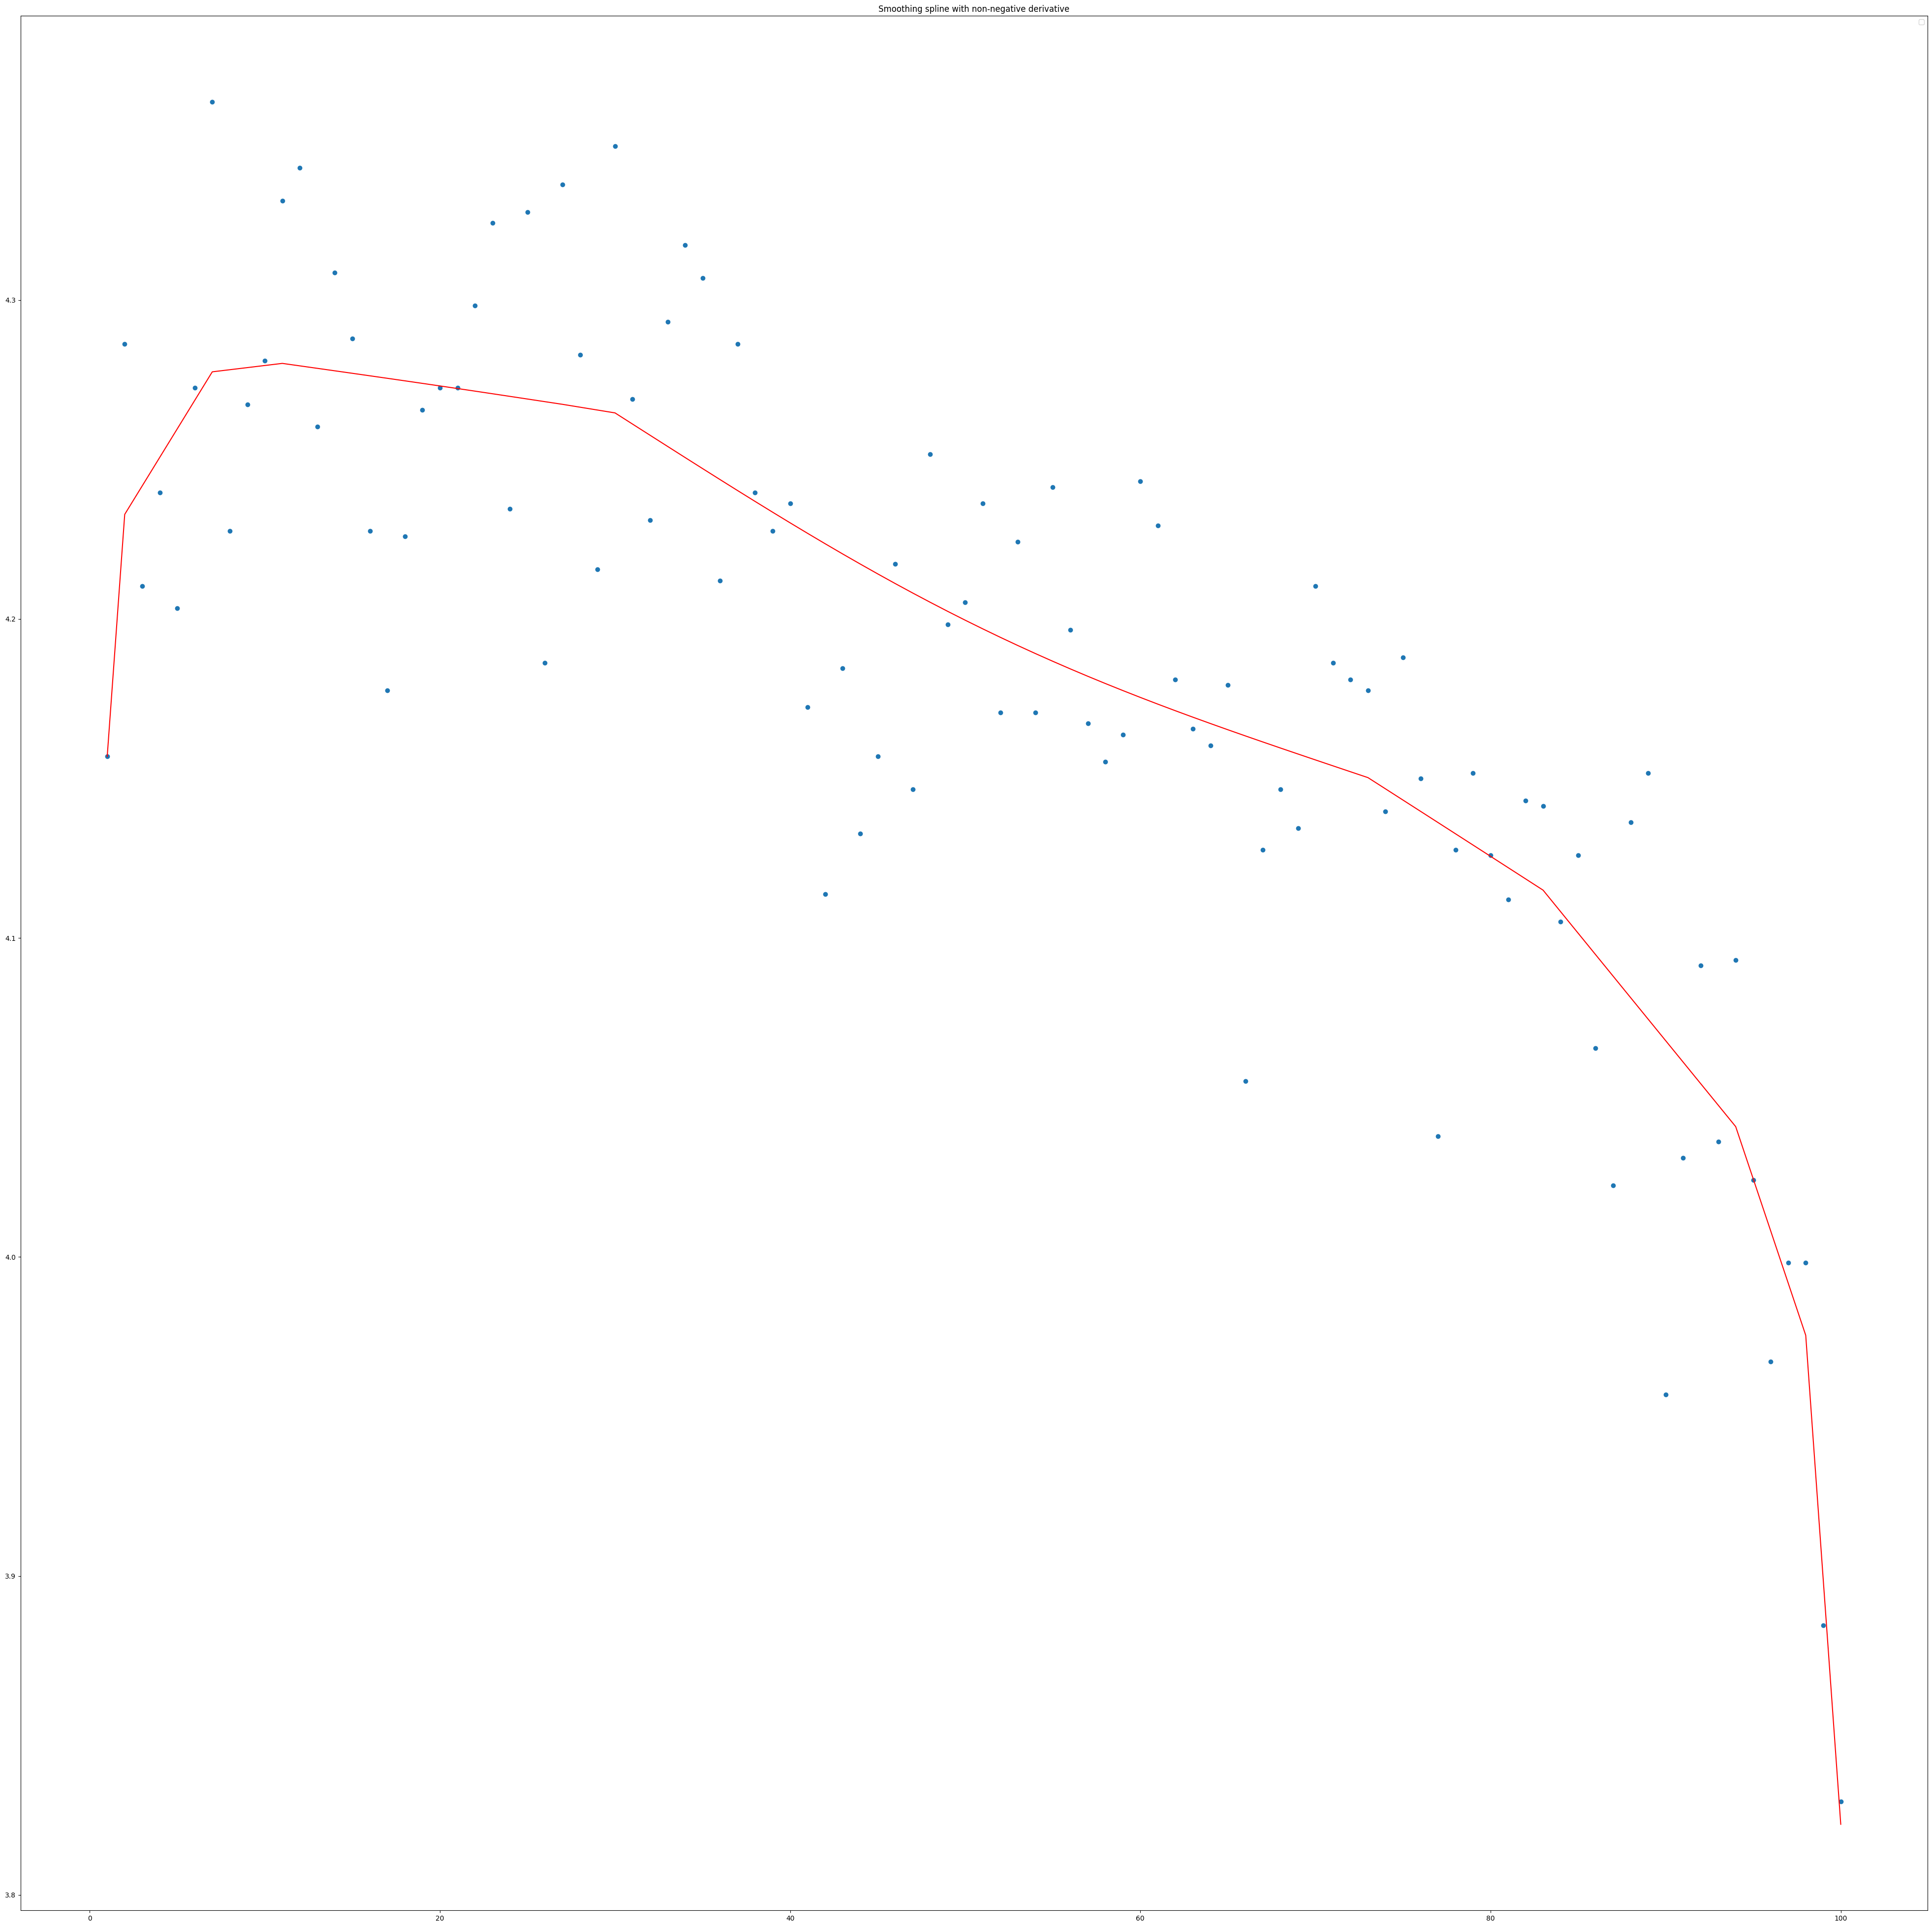

In [16]:
plot_constrained_spline(df=examples_df, xlabel="rank",groupby='example_idx', ylabel=compare_metric, title=suptitle)

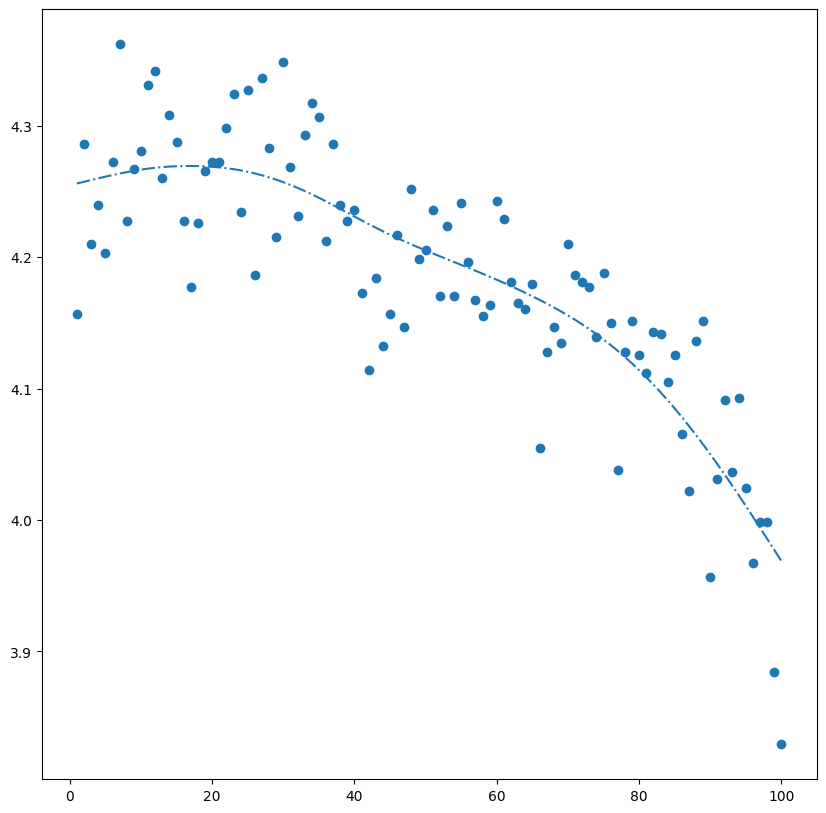

In [28]:

def plot_smooth_spline2(df, xlabel, ylabel, groupby='example_idx', title=None, trend_line="None",ax=None, nbins=20, error_bar=False, figsize=(50,50)):
    if(ax is None):
        _, ax = plt.subplots(figsize=figsize)
    warnings.simplefilter(action='ignore', category=FutureWarning)
    if(groupby=="bins"):
        
        df["bins"]=pd.qcut(df[xlabel],nbins)
    
    grouped = df.groupby(groupby)[[xlabel, ylabel]].agg(['mean', 'count', 'std'])
    
    grouped = grouped.sort_values(by=(xlabel, 'mean'))

    x = grouped[(xlabel, 'mean')].values
    y = grouped[(ylabel, 'mean')].values
    

    yerr = grouped[(ylabel, 'std')].values
    yerr=[]
    for i in grouped.index:
        # print(grouped.loc[i][ylabel])
        _, c, s = grouped.loc[i][ylabel]
        yerr.append(1.96*s/math.sqrt(c))

    # Plot with error bars (standard deviation)

    if(error_bar):
        ax.errorbar(x, y, yerr=yerr, fmt='o', ecolor='gray', capsize=3, label='Data with std dev')
    else:
        ax.scatter(x,y)
    
    for lam in [10000]:
        spl = make_smoothing_spline(x, y, lam=lam)
        plt.plot(x, spl(x), '-.', label=fr'$\lambda=${lam}')
    # plt.plot(x, spl(x), '-.')
plot_smooth_spline2(df=examples_df, xlabel="rank",groupby='example_idx', ylabel=compare_metric, title=suptitle, figsize=(10,10), error_bar=False)